In [2]:
import json
import uproot
from XRootD import client
import xgboost as xgb
import os
import sys
sys.path.append("../../analysisTools/")
from skimmerTools import Skimmer
from analysisTools import Analyzer
from analysisTools import loadSchema
import plotTools as ptools
import coffea
import coffea.util as util
import numpy as np
import awkward as ak
import time
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import mplhep
import glob
import hist
import matplotlib as mpl


### Run Skimmers on skimmed ntuples with preselections, produce h5 files for BDT input

In [3]:
outdir = "./h5/"
os.system(f"mkdir -p {outdir}")

0

In [4]:
def write_h5(data,fname):
    with h5py.File(fname,'w') as f:
        for k in data.keys():
            arr = data[k].value
            if type(arr) == np.ma.core.MaskedArray:
                arr = arr.data
            f.create_dataset(k,data=arr)

In [5]:
suffix = "_TrueVertexForSignal"

In [6]:
cut_config = "./preselections.py"

In [ ]:
sig_sample_json_dir = './'
jsons = [f for f in os.listdir(sig_sample_json_dir) if ".json" in f]

signal_list = [ samp.split('.')[0] for samp in jsons if "skimmed_sig_v2_mA_3m1_2018_aEM" in samp ]
print(signal_list)

bkg_sample_json_dir = '../../configs/sample_configs/'
jsons = [f for f in os.listdir(bkg_sample_json_dir) if ".json" in f]

bkg_list = [ samp.split('.')[0] for samp in jsons if "skimmed_bkg" in samp ]
print(bkg_list)

In [ ]:
for samp in signal_list:
    print(f'Start analyzing: {samp}')
    
    test = Skimmer(f"{sig_sample_json_dir}/{samp}.json", cut_config)
    
    t1 = time.time()
    out = test.process(execr='futures')
    t2 = time.time()

    write_h5(out[0],f"{outdir}/{samp}{suffix}.h5")
    
    print('Completed in {:.2f} min\n'.format((t2-t1)/60))
    del out, test

In [101]:
for samp in bkg_list:
    if 'TTJetsDiLept' in samp: # currently not available ntuples
        continue
    
    print(f'Start analyzing: {samp}')
    
    test = Skimmer(f"{bkg_sample_json_dir}/{samp}.json", cut_config)
    
    t1 = time.time()
    out = test.process(execr='futures')
    t2 = time.time()

    write_h5(out[0],f"{outdir}/{samp}{suffix}.h5")
    
    print('Completed in {:.2f} min\n'.format((t2-t1)/60))
    del out, test

Start analyzing: skimmed_bkg_2018_DY


Output()

Output()

Completed in 0.79 min

Start analyzing: skimmed_bkg_2018_Diboson


Output()

Output()

Completed in 0.59 min

Start analyzing: skimmed_bkg_2018_QCD_TuneCP5_PSWeights


Output()

Output()

Completed in 2.39 min

Start analyzing: skimmed_bkg_2018_Top


Output()

Output()

Completed in 3.67 min

Start analyzing: skimmed_bkg_2018_Triboson


Output()

Output()

Completed in 0.25 min

Start analyzing: skimmed_bkg_2018_WJets


Output()

Output()

Completed in 2.60 min

Start analyzing: skimmed_bkg_2018_ZJets


Output()

Output()

Completed in 2.43 min



## BDT -- high Vxy region: vxy > 0.5

In [7]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import xgboost as xgb
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

In [70]:
h5_dir = "./h5/"
sig_suffix = "_TrueVertexForSignal"
bkg_suffix = "_TrueVertexForSignal"

sig_files = [f for f in os.listdir(h5_dir) if sig_suffix in f and 'sig' in f]
bkg_files = [f for f in os.listdir(h5_dir) if bkg_suffix in f and 'bkg' in f]

# vtx variables
variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR','sel_vtx_minDxy','vxy_signif']

sig_data = []

sig_xsec_norm = []
sig_point = {'m1':[], 'delta':[], 'ctau':[]}

for sf in sig_files:
    with h5py.File(f'{h5_dir}/{sf}',"r") as fin:
        entries = len(fin['wgt'])

        '''
        match = fin["sel_vtx_match"][()]
        mask = match==2

        entries_genMatched = sum(mask)
        print(f'Signal events {entries} -> {entries_genMatched} after gen matching (raw counts)\n')
        '''

        # Vxy mask
        vxy_thres = 0.5
        vxy_val = fin["vxy"][()]
        print(vxy_val)
        vxy_mask = vxy_val <= vxy_thres
        print(vxy_mask)
        entries_vxy_mask = sum(vxy_mask)
        
        sig_data.append(np.concatenate([fin[v][()][vxy_mask].reshape(-1,1) for v in variables],axis=1))
        sig_xsec_norm.append(fin['wgt_norm'][()][vxy_mask])
        
        sig_point['m1'].append(fin['m1'][()][vxy_mask])
        sig_point['delta'].append(fin['delta'][()][vxy_mask])
        sig_point['ctau'].append(fin['ctau'][()][vxy_mask])

        print(f'Signal events {entries} -> {entries_vxy_mask} after vxy cut (raw counts)\n')

sig_data = np.concatenate(sig_data,axis=0)
sig_xsec_norm = np.concatenate(sig_xsec_norm,axis=0)
sig_point['m1'] = np.concatenate(sig_point['m1'], axis=0)
sig_point['delta'] = np.concatenate(sig_point['delta'], axis=0)
sig_point['ctau'] = np.concatenate(sig_point['ctau'], axis=0)

nBkg = 0
bkg_data = []

bkg_xsec_norm = []

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        entries = len(fin['wgt'])
        #print(f'{process}: {entries}')
        #nBkg += len(fin['wgt'])

        vxy_val = fin["vxy"][()]
        vxy_mask = vxy_val <= vxy_thres
        entries_vxy_mask = sum(vxy_mask)

        print(f'{process}: {entries}, after vxy cut {entries_vxy_mask}')
        nBkg += len(fin['wgt'][vxy_mask])
        
        bkg_data.append(np.concatenate([fin[v][()][vxy_mask].reshape(-1,1) for v in variables],axis=1))
        bkg_xsec_norm.append(fin['wgt_norm'][()][vxy_mask])

bkg_xsec_norm = np.concatenate(bkg_xsec_norm,axis=0)


print(f'\nNumber of total background events (raw counts): {nBkg}')

bkg_data = np.concatenate(bkg_data,axis=0)

[58.565445   8.085202   1.0170088 ...  4.23203    0.7303197  2.5345237]
[False False False ... False False False]
Signal events 12409 -> 5845 after vxy cut (raw counts)

DY: 9, after vxy cut 7
Diboson: 767, after vxy cut 348
QCD: 3, after vxy cut 2
Top: 2006, after vxy cut 1034
Triboson: 92, after vxy cut 42
WJets: 29090, after vxy cut 12496
ZJets: 44480, after vxy cut 18372

Number of total background events (raw counts): 32301


In [9]:
print('Signal input statistics (unweighted)')

sig_subprocess = {}

for delta in [0.1, 0.2]:
    for m1 in [5.,10.,20.,30.,40.,50.]:
        for ctau in [1., 10., 100.]:
            idx = ((sig_point['m1'] == m1) & (sig_point['delta'] == delta))&(sig_point['ctau'] == ctau)
            point = f'm1_{m1}_delta_{delta}_ctau_{ctau}'
            sig_subprocess[point] = idx
            print(f'{point}: {np.sum(idx)}')

nSamp = 0
for samp, count in sig_subprocess.items():
    if np.sum(count) != 0:
        nSamp += 1
    else:
        print(f'{samp} has zero counts')

print(f'Number of signal subprocesses with non-zero count: {nSamp}')

Signal input statistics (unweighted)
m1_5.0_delta_0.1_ctau_1.0: 47
m1_5.0_delta_0.1_ctau_10.0: 9
m1_5.0_delta_0.1_ctau_100.0: 9
m1_10.0_delta_0.1_ctau_1.0: 156
m1_10.0_delta_0.1_ctau_10.0: 26
m1_10.0_delta_0.1_ctau_100.0: 9
m1_20.0_delta_0.1_ctau_1.0: 288
m1_20.0_delta_0.1_ctau_10.0: 53
m1_20.0_delta_0.1_ctau_100.0: 6
m1_30.0_delta_0.1_ctau_1.0: 438
m1_30.0_delta_0.1_ctau_10.0: 110
m1_30.0_delta_0.1_ctau_100.0: 15
m1_40.0_delta_0.1_ctau_1.0: 568
m1_40.0_delta_0.1_ctau_10.0: 154
m1_40.0_delta_0.1_ctau_100.0: 30
m1_50.0_delta_0.1_ctau_1.0: 984
m1_50.0_delta_0.1_ctau_10.0: 236
m1_50.0_delta_0.1_ctau_100.0: 45
m1_5.0_delta_0.2_ctau_1.0: 66
m1_5.0_delta_0.2_ctau_10.0: 5
m1_5.0_delta_0.2_ctau_100.0: 1
m1_10.0_delta_0.2_ctau_1.0: 186
m1_10.0_delta_0.2_ctau_10.0: 32
m1_10.0_delta_0.2_ctau_100.0: 1
m1_20.0_delta_0.2_ctau_1.0: 390
m1_20.0_delta_0.2_ctau_10.0: 79
m1_20.0_delta_0.2_ctau_100.0: 18
m1_30.0_delta_0.2_ctau_1.0: 616
m1_30.0_delta_0.2_ctau_10.0: 134
m1_30.0_delta_0.2_ctau_100.0: 14
m1_4

## Reweight Backgrounds

### Background raw counts

In [10]:
bkg_raw = {}
nBkg = 0

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        #entries = len(fin['wgt'])

        vxy_val = fin["vxy"][()]
        vxy_mask = vxy_val <= vxy_thres

        entries = len(fin['wgt'][vxy_mask])
        
        print(f'{process}: {entries}')
        nBkg += len(fin['wgt'][vxy_mask])

        bkg_raw[process] = entries

DY: 7
Diboson: 348
QCD: 2
Top: 1034
Triboson: 42
WJets: 12496
ZJets: 18372


### Cutflow counts (xsec weighted)

In [11]:
bkg_cts = {}
total_bkg_cts = 0

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]

        vxy_val = fin["vxy"][()]
        vxy_mask = vxy_val <= vxy_thres
        
        entries = sum(fin['wgt_norm'][()][vxy_mask])
        print(f'{process}: {entries}')

        total_bkg_cts += entries
        
        bkg_cts[process] = entries

print(f'Total background counts (xsec weighted): {total_bkg_cts}')

DY: 407.4727973937988
Diboson: 86.22685298323631
QCD: 624.407470703125
Top: 154.45645013265312
Triboson: 1.1586303324438632
WJets: 4750.183484834444
ZJets: 2562.321437094477
Total background counts (xsec weighted): 8586.227123474178


### Reweighing factor = `wgt_norm` / `total_bkg_cts` * `nBkg`

Reweigh the background samples, such that after reweighting the total number of backgrounds (BDT sample size) are unchanged but the relative contributions of each sub-process within the BDT sample are physically correct.

In [12]:
nBkg

32301

In [13]:
sf = {}
xsec_norm = {}

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]

        vxy_val = fin["vxy"][()]
        vxy_mask = vxy_val <= vxy_thres
        
        entries = fin['wgt_norm'][()][vxy_mask] / total_bkg_cts * nBkg
        print(f'{process}: {entries}')

        sf[process] = entries
        xsec_norm[process] = fin['wgt_norm'][()][vxy_mask]

DY: [539.8742   539.8742    90.629166  90.629166  90.629166  90.629166
  90.629166]
Diboson: [0.81387216 0.81387216 0.81387216 0.81387216 0.81387216 0.81387216
 0.81387216 0.81387216 0.81387216 0.81387216 0.81387216 0.81387216
 0.81387216 0.81387216 0.81387216 0.81387216 0.81387216 0.81387216
 0.81387216 0.81387216 0.81387216 0.81387216 0.81387216 0.81387216
 0.81387216 0.81387216 0.81387216 0.81387216 0.81387216 0.81387216
 0.81387216 0.81387216 0.81387216 0.81387216 0.81387216 0.81387216
 0.81387216 0.81387216 0.81387216 0.81387216 0.81387216 0.81387216
 0.81387216 0.81387216 0.81387216 0.81387216 0.81387216 0.81387216
 0.81387216 0.81387216 0.81387216 0.81387216 0.81387216 0.81387216
 0.81387216 0.81387216 0.81387216 0.81387216 0.81387216 0.81387216
 0.81387216 0.81387216 0.81387216 0.81387216 0.81387216 0.81387216
 0.81387216 0.81387216 0.81387216 0.81387216 0.81387216 0.74518156
 0.74518156 0.74518156 0.74518156 0.74518156 0.74518156 0.74518156
 0.74518156 0.74518156 0.74518156 0.

**With the weight applied, the total bkg events are the same as raw counts, but the contribution of the relative xsec is considered now.**

In [14]:
total_weighted = 0

for process in sf.keys():
    print(f'{process}: {sum(sf[process])}')
    total_weighted += sum(sf[process])

print(total_weighted)

DY: 1532.8942413330078
Diboson: 324.3815203309059
QCD: 2348.99267578125
Top: 581.058180321008
Triboson: 4.35871502943337
WJets: 17869.97559214267
ZJets: 9639.337219053414
32300.99814399169


In [15]:
nBkg

32301

In [16]:
# SF
bkg_sf = []
bkg_xsec_norm = []

for process in sf.keys():
    bkg_sf += list(sf[process])
    bkg_xsec_norm += list(xsec_norm[process])

print(len(bkg_sf))

32301


In [17]:
set(bkg_xsec_norm)

{-0.016287146,
 -0.012563892,
 -0.0042385785,
 0.00075470324,
 0.0012511426,
 0.0042385785,
 0.004238579,
 0.01063748,
 0.012563892,
 0.016287146,
 0.024323996,
 0.028713468,
 0.030013198,
 0.037092578,
 0.038779505,
 0.039841752,
 0.043379143,
 0.045444746,
 0.05953975,
 0.08565486,
 0.18472649,
 0.19808361,
 0.2163429,
 0.2441929,
 0.2524531,
 0.29107392,
 0.34455764,
 0.3913622,
 0.55844516,
 1.1887455,
 2.7895231,
 24.090977,
 143.50896,
 312.20374}

In [18]:
len(bkg_sf)

32301

## Reweight Signal

For signal, we also apply the reweighting factors.
1) First, since our signal samples are smaller than background samples, get the overall scale factor for signal samples to match the total number of background samples. Reweigh against background.
2) Then, reweigh across signal samples. We will make all signal subprocesses "equally shown" to the BDT. Currently the inputs are biased, i.e. to have more 10% splitting, 1mm ctau, etc. We will flatten these out.

In [19]:
bkg_to_sig = len(bkg_xsec_norm)/len(sig_xsec_norm)

print(f'Signal sample size (all subprocesses summed): {len(sig_xsec_norm)}')
print(f'Background sample size (all subprocesses summed): {len(bkg_xsec_norm)}')
print(f'{bkg_to_sig} more background than signal samples')

Signal sample size (all subprocesses summed): 5845
Background sample size (all subprocesses summed): 32301
5.526261762189906 more background than signal samples


In [20]:
print(f'There are {nSamp} subprocesses in signal, i.e. per m1/delta/ctau points.')
print(f'\nIdeally, sig and bkg sample size for BDT input should be the same.')
print(f'\nFor background, we care about each background process contribution to the total, i.e. QCD having higher xsec than Diboson.')
print(f'This should be taken into account, so we got the SF for background input that will correct for this relative xsec contribution.')
print(f'\nFor signal, we want BDT to equally "see" each subprocess. For example, delta=0.2 splitting has lower xsec than delta=0.1.')
print(f'But we want the BDT to "equally" see them. Therefore, we reweigh signal such that each subprocess relative contribution is the same.')
print(f'For signal, we also get the overall SF against bkg, because right now we have 10 times less signal input than background.')

There are 36 subprocesses in signal, i.e. per m1/delta/ctau points.

Ideally, sig and bkg sample size for BDT input should be the same.

For background, we care about each background process contribution to the total, i.e. QCD having higher xsec than Diboson.
This should be taken into account, so we got the SF for background input that will correct for this relative xsec contribution.

For signal, we want BDT to equally "see" each subprocess. For example, delta=0.2 splitting has lower xsec than delta=0.1.
But we want the BDT to "equally" see them. Therefore, we reweigh signal such that each subprocess relative contribution is the same.
For signal, we also get the overall SF against bkg, because right now we have 10 times less signal input than background.


In [21]:
print(f'This means, for each one of {nSamp} signal subprocesses, there should be [n(background sample size)/n(number of signal subprocess)] = {len(bkg_xsec_norm)/nSamp}')

This means, for each one of 36 signal subprocesses, there should be [n(background sample size)/n(number of signal subprocess)] = 897.25


In [22]:
print(f'We will get the SF for each signal subprocess such that their weighted count corresponds to {len(bkg_xsec_norm)/nSamp}')

We will get the SF for each signal subprocess such that their weighted count corresponds to 897.25


In [23]:
sig_sf = np.zeros(len(sig_xsec_norm)) # initialize

nSubprocessWeighted = len(bkg_xsec_norm)/nSamp
#nSubprocessWeighted = nSamp

for samp, idx in sig_subprocess.items():
    samp_idx = np.nonzero(idx)[0]
    nSubprocess = np.sum(idx) # unweighted
    if nSubprocess == 0:
        continue
    sf = nSubprocessWeighted/nSubprocess

    sig_sf[samp_idx] = sf

print(sig_sf)

[897.25        13.59469697  13.59469697 ...   5.75160256   5.75160256
   5.75160256]


In [24]:
type(sig_sf)

numpy.ndarray

### Train

In [25]:
bkg_sf_arr = np.array(bkg_sf)
sig_sf_arr = sig_sf

In [26]:
rng = np.random.default_rng(seed=438290)
random_state = rng.integers(0,100000,1)[0]

# 8-2 split of train/test set; shuffle the array of SFs accordingly
sig_train, sig_test = train_test_split(sig_data,train_size=0.8,random_state=random_state)
sig_train_sf, sig_test_sf = train_test_split(sig_sf_arr, train_size=0.8, random_state=random_state)
sig_train_xsec_norm, sig_test_xsec_norm = train_test_split(sig_xsec_norm, train_size=0.8, random_state=random_state)
sig_train_m1, sig_test_m1 = train_test_split(sig_point['m1'], train_size=0.8, random_state=random_state)
sig_train_delta, sig_test_delta = train_test_split(sig_point['delta'], train_size=0.8, random_state=random_state)
sig_train_ctau, sig_test_ctau = train_test_split(sig_point['ctau'], train_size=0.8, random_state=random_state)

bkg_train, bkg_test = train_test_split(bkg_data,train_size=0.8,random_state=random_state)
bkg_train_sf, bkg_test_sf = train_test_split(bkg_sf_arr, train_size=0.8, random_state=random_state)
bkg_train_xsec_norm, bkg_test_xsec_norm = train_test_split(bkg_xsec_norm, train_size=0.8, random_state=random_state)

bkg_train_m1, bkg_test_m1 = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=0.8, random_state=random_state)
bkg_train_delta, bkg_test_delta = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=0.8, random_state=random_state)
bkg_train_ctau, bkg_test_ctau = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=0.8, random_state=random_state)

train = np.concatenate((sig_train,bkg_train),axis=0)
train_sf = np.concatenate((sig_train_sf,bkg_train_sf),axis=0)
train_sf = abs(train_sf)  # training sf cannot have negative values, genWgts have negative values, take abs for now, which is not correct :( 

y_train = np.concatenate((np.ones(len(sig_train)),np.zeros(len(bkg_train))),axis=0)

perm = rng.permutation(len(train))
train = train[perm]
y_train = y_train[perm]
dtrain = xgb.DMatrix(train,label=y_train,feature_names=variables)

test = np.concatenate((sig_test,bkg_test),axis=0)
test_sf = np.concatenate((sig_test_sf,bkg_test_sf),axis=0) # not used

test_xsec_norm = np.concatenate((sig_test_xsec_norm, bkg_test_xsec_norm), axis=0)

test_m1 = np.concatenate((sig_test_m1,bkg_test_m1),axis=0)
test_delta = np.concatenate((sig_test_delta,bkg_test_delta),axis=0)
test_ctau = np.concatenate((sig_test_ctau,bkg_test_ctau),axis=0)

y_test = np.concatenate((np.ones(len(sig_test)),np.zeros(len(bkg_test))),axis=0)

perm = rng.permutation(len(test))
test = test[perm]
y_test = y_test[perm]
test_xsec_norm = test_xsec_norm[perm]
test_m1 = test_m1[perm]
test_delta = test_delta[perm]
test_ctau = test_ctau[perm]

dtest = xgb.DMatrix(test,label=y_test,feature_names=variables)

In [29]:
set(test_ctau[np.where(y_test == 1)]) # signal

{1.0, 10.0, 100.0}

In [30]:
test_ctau[np.where(y_test == 0)] # bkg; should all be zeros by construction, printing out to check if this is the case (not messed up by random_state)

array([0., 0., 0., ..., 0., 0., 0.])

In [31]:
bst = xgb.XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.05, objective='binary:logistic')

# fit model
bst.fit(train, y_train, sample_weight=train_sf)
#bst.fit(train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='binary:logistic', predictor=None, ...)

In [32]:
# make predictions
preds = bst.predict(test)

In [33]:
os.system('mkdir -p plots')

0

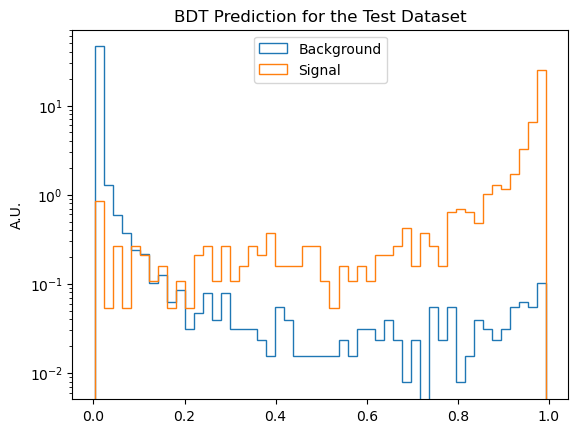

In [34]:
bins = 50

h,bins,_ = plt.hist(preds[y_test==0],bins=bins,density=True,histtype='step', label='Background')
h,bins,_ = plt.hist(preds[y_test==1],bins=bins,density=True,histtype='step', label='Signal')

plt.legend()
plt.title('BDT Prediction for the Test Dataset')

plt.ylabel('A.U.')
plt.savefig('plots/BDT_lowLxy_thres_0p5_score.png')
plt.yscale('log')

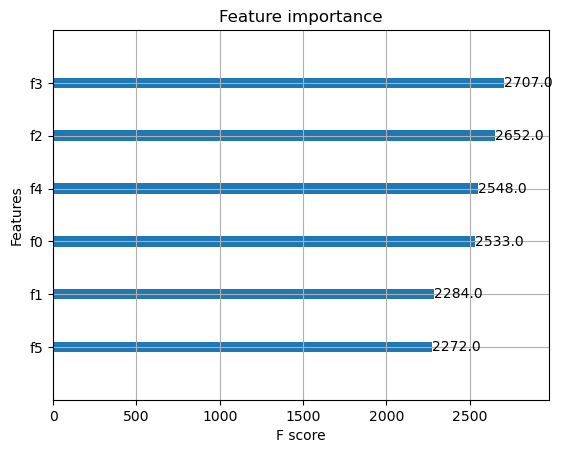

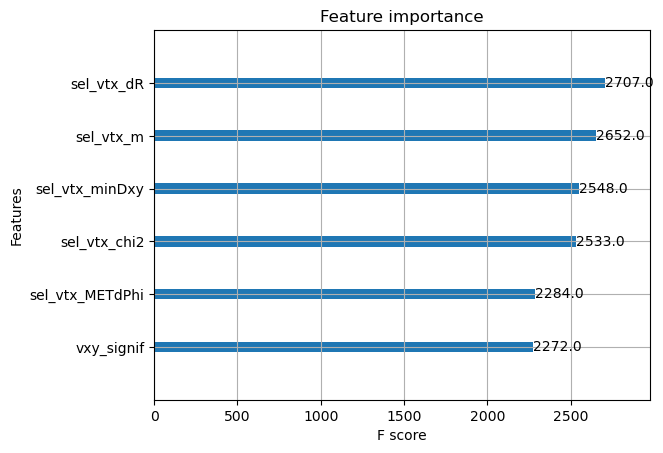

In [35]:
# Label the feature importance plot: replace, i.e. f1 with the variable name lead_jet_pt
label_dict = {}

for idx, var in enumerate(variables):
    label_dict['f{}'.format(idx)] = var
#print(label_dict)

# Plot importance

xgb.plot_importance(bst)

ticks = [ item.get_text() for item in plt.gca().get_yticklabels() ]
#print(ticks)
relabel = [ label_dict[tick] for tick in ticks ]
#print(relabel)

# Plot importance with axis with variable names
xgb.plot_importance(bst).set_yticklabels(relabel)
plt.savefig('plots/BDT_lowLxy_thres_0p5_importance_bst.png', bbox_inches = "tight")

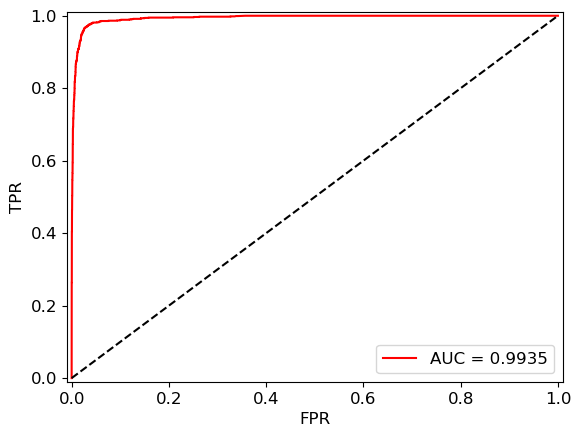

In [36]:
# ROC
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve

# make predictions

fpr, tpr, thresholds = roc_curve(y_test, preds)
auc = roc_auc_score(y_test, preds)
precision, recall, thresholds2 = precision_recall_curve(y_test, preds)

plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.4f}")

plt.plot([0,1], [0,1] , color = "black", ls = "--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('FPR' , fontsize=12)
plt.ylabel('TPR' , fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 4)
plt.savefig('plots/BDT_lowLxy_thres_0p5_roc_curve.png')

### Save and load

In [37]:
os.system('mkdir -p models')

0

In [38]:
bst.save_model('models/BDT_lowLxy_thres_0p5.json')

In [39]:
trained_model = xgb.XGBRegressor()
trained_model.load_model("models/BDT_lowLxy_thres_0p5.json")

In [40]:
prediction = trained_model.predict(test)

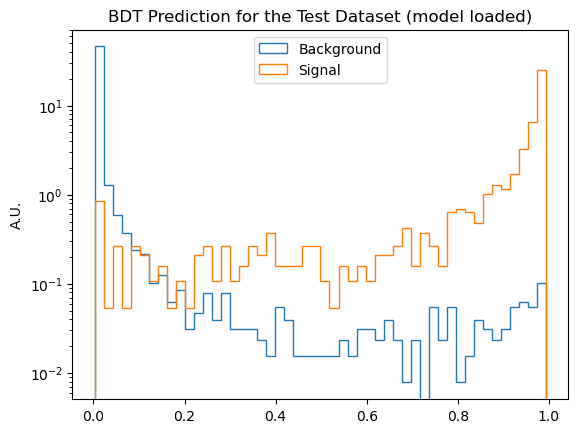

In [41]:
bins = 50

h_bkg,bins,_ = plt.hist(prediction[y_test==0],bins=bins,density=True,histtype='step', label='Background')
h_sig,bins,_ = plt.hist(prediction[y_test==1],bins=bins,density=True,histtype='step', label='Signal')

plt.legend()
plt.title('BDT Prediction for the Test Dataset (model loaded)')

plt.ylabel('A.U.')
plt.yscale('log')

In [42]:
h_sig = h_sig[::-1]
h_sig

array([25.07083639,  6.61443343,  3.25386471,  1.70695056,  1.17352851,
        1.28021292,  1.0135019 ,  0.48007985,  0.64010453,  0.69344867,
        0.64010646,  0.16002662,  0.26671103,  0.37339431,  0.16002662,
        0.42673764,  0.26671103,  0.21336882,  0.21336818,  0.10668441,
        0.16002662,  0.10668441,  0.16002662,  0.05334221,  0.10668425,
        0.26671062,  0.26671103,  0.16002662,  0.16002637,  0.16002662,
        0.37339487,  0.21336882,  0.26671103,  0.16002637,  0.10668441,
        0.26671103,  0.10668425,  0.26671103,  0.21336866,  0.05334216,
        0.10668433,  0.05334221,  0.16002649,  0.10668433,  0.21336874,
        0.26671082,  0.05334219,  0.26671082,  0.05334217,  0.85347483])

In [43]:
h_bkg = h_bkg[::-1]
h_bkg

array([1.01639976e-01, 5.47292180e-02, 6.25474894e-02, 5.47292180e-02,
       3.12738389e-02, 2.34553791e-02, 3.12738389e-02, 3.90922986e-02,
       1.56368723e-02, 7.81845971e-03, 5.47292180e-02, 2.34553791e-02,
       5.47292180e-02, 0.00000000e+00, 2.34553791e-02, 7.81845971e-03,
       2.34553791e-02, 3.90922986e-02, 2.34553085e-02, 3.12738389e-02,
       3.12738389e-02, 1.56369194e-02, 2.34553791e-02, 1.56369194e-02,
       1.56368959e-02, 1.56368959e-02, 1.56369194e-02, 1.56369194e-02,
       3.90922397e-02, 5.47292180e-02, 1.56368959e-02, 2.34553791e-02,
       3.12738389e-02, 3.12737918e-02, 3.12738389e-02, 7.81845971e-02,
       3.90922397e-02, 7.81845971e-02, 4.69107230e-02, 3.12738153e-02,
       8.60029921e-02, 6.25476777e-02, 1.25095261e-01, 1.01639900e-01,
       2.18916790e-01, 2.42372069e-01, 3.67467468e-01, 5.86384037e-01,
       1.29004512e+00, 4.60819755e+01])

In [44]:
# S/B scan on the score (xsec unweighted)
h_sig_sum = []
h_bkg_sum = []

for idx, entry in enumerate(h_sig):
    integral = 0
    for j in range(idx):
        integral += h_sig[j]
    h_sig_sum.append(integral)

for idx, entry in enumerate(h_bkg):
    integral = 0
    for j in range(idx):
        integral += h_bkg[j]
    h_bkg_sum.append(integral)

np.array(h_sig_sum)/np.array(h_bkg_sum)

/tmp/ipykernel_17258/326739833.py:17: RuntimeWarning: invalid value encountered in divide
  np.array(h_sig_sum)/np.array(h_bkg_sum)


array([         nan, 246.66314678, 202.631151  , 159.60014534,
       133.91790219, 124.03137147, 119.07061219, 111.53467145,
       101.80388296,  99.50697171,  99.30672712,  89.25301859,
        85.38909079,  77.4509093 ,  78.12355803,  75.23297738,
        74.95761466,  72.51197454,  68.47258172,  66.40133871,
        63.60178016,  61.11306288,  59.98201106,  58.37111911,
        57.28280541,  56.30299663,  55.555445  ,  54.83583814,
        54.01745355,  51.82781132,  48.99866227,  48.5902144 ,
        47.64989452,  46.44615101,  45.21244475,  44.00081679,
        41.25828065,  39.99915644,  37.75450164,  36.57558711,
        35.76934602,  33.70512048,  32.33627421,  29.94727204,
        28.24741122,  25.18059517,  22.51457633,  19.29940018,
        15.78362476,  11.20253934])

[Text(0, 0, 'vxy_signif'),
 Text(0, 1, 'sel_vtx_METdPhi'),
 Text(0, 2, 'sel_vtx_chi2'),
 Text(0, 3, 'sel_vtx_minDxy'),
 Text(0, 4, 'sel_vtx_m'),
 Text(0, 5, 'sel_vtx_dR')]

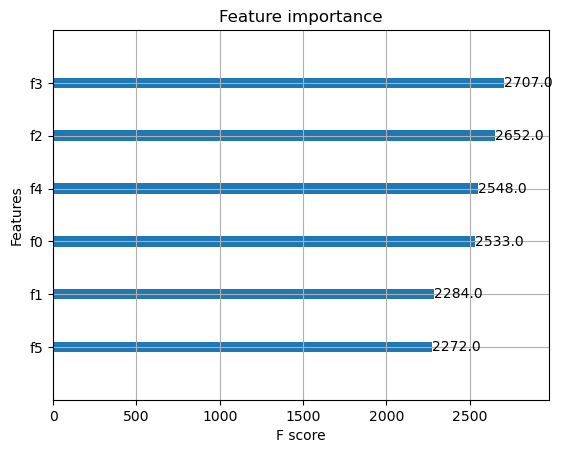

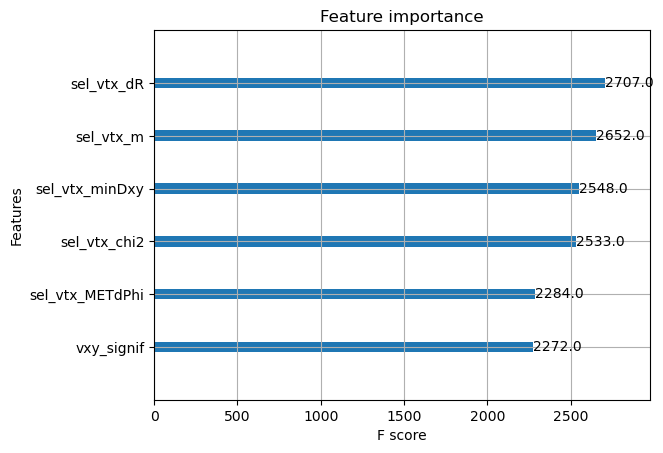

In [45]:
# Label the feature importance plot: replace, i.e. f1 with the variable name lead_jet_pt
label_dict = {}

for idx, var in enumerate(variables):
    label_dict['f{}'.format(idx)] = var
#print(label_dict)

# Plot importance

xgb.plot_importance(trained_model)

ticks = [ item.get_text() for item in plt.gca().get_yticklabels() ]
#print(ticks)
relabel = [ label_dict[tick] for tick in ticks ]
#print(relabel)

# Plot importance with axis with variable names
xgb.plot_importance(trained_model).set_yticklabels(relabel)
#plt.savefig('plots/importance_bst_weighted.png', bbox_inches = "tight")

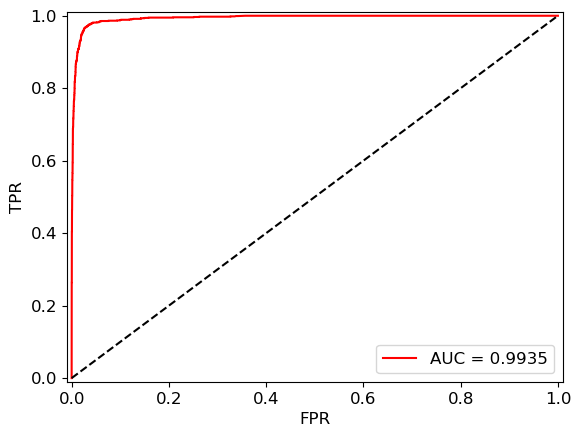

In [46]:
# ROC
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve

# make predictions

fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc = roc_auc_score(y_test, prediction)
precision, recall, thresholds2 = precision_recall_curve(y_test, prediction)

plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.4f}")

plt.plot([0,1], [0,1] , color = "black", ls = "--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('FPR' , fontsize=12)
plt.ylabel('TPR' , fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 4)
#plt.savefig('plots/roc_curve_weighted_training.png')

### WP

In [47]:
idx_valid = thresholds < 1

tpr = tpr[idx_valid]
thresholds = thresholds[idx_valid]

In [48]:
tpr_WP = {'tight': 0.7, 'medium': 0.8, 'loose': 0.9}
thres_WP = {'tight': 0, 'medium': 0, 'loose': 0}

In [49]:
epsilon = 0.015

for wp in tpr_WP.keys():    
    idx = np.where((tpr > tpr_WP[wp] - epsilon) & (tpr < tpr_WP[wp] + epsilon))
    
    thres_WP[wp] = thresholds[idx].mean()

    print(f'{wp} threshold: {thres_WP[wp]}')

tight threshold: 0.9541754722595215
medium threshold: 0.8974997997283936
loose threshold: 0.6195806860923767


### TPR

In [50]:
# BDT scores for the signal
nPass_sig = {'tight': 0, 'medium': 0, 'loose': 0}
nPass_bkg = {'tight': 0, 'medium': 0, 'loose': 0}

for wp in nPass_sig.keys():
    nPass_sig[wp] = np.sum(preds[np.where(y_test==1)] > thres_WP[wp])
    nPass_bkg[wp] = np.sum(preds[np.where(y_test==0)] > thres_WP[wp])
    
    print(f'\n{wp} pass')
    print(f'TPR: {nPass_sig[wp]} / {len(preds[np.where(y_test==1)])} = {nPass_sig[wp]/len(preds[np.where(y_test==1)])}')
    print(f'FPR: {nPass_bkg[wp]} / {len(preds[np.where(y_test==0)])} = {nPass_bkg[wp]/len(preds[np.where(y_test==0)])}')


tight pass
TPR: 814 / 1169 = 0.6963216424294268
FPR: 20 / 6461 = 0.003095496053242532

medium pass
TPR: 928 / 1169 = 0.7938408896492729
FPR: 38 / 6461 = 0.005881442501160811

loose pass
TPR: 1058 / 1169 = 0.9050470487596236
FPR: 86 / 6461 = 0.013310633028942889


In [51]:
# for a given point
m1 = 30.
delta = 0.1
ctau = 1.

nPass_sig_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
nPass_bkg_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}

for wp in nPass_sig.keys():
    sig_idx = np.where(((y_test==1) & (test_m1 == m1)) & ((test_delta == delta) & (test_ctau == ctau)))
    bkg_idx = np.where(y_test==0)
    
    nPass_sig_sigpoint[wp] = np.sum(preds[sig_idx] > thres_WP[wp])
    nPass_bkg_sigpoint[wp] = np.sum(preds[bkg_idx] > thres_WP[wp])
    
    print(f'\n{wp} pass')
    print(f'TPR: {nPass_sig_sigpoint[wp]} / {len(preds[sig_idx])} = {nPass_sig_sigpoint[wp]/len(preds[sig_idx])}')
    print(f'FPR: {nPass_bkg_sigpoint[wp]} / {len(preds[bkg_idx])} = {nPass_bkg_sigpoint[wp]/len(preds[bkg_idx])}')


tight pass
TPR: 55 / 73 = 0.7534246575342466
FPR: 20 / 6461 = 0.003095496053242532

medium pass
TPR: 63 / 73 = 0.863013698630137
FPR: 38 / 6461 = 0.005881442501160811

loose pass
TPR: 68 / 73 = 0.9315068493150684
FPR: 86 / 6461 = 0.013310633028942889


### TPR per signal point

In [52]:
tpr_raw = { '0.1': {'ct-1': {'tight':[], 'medium':[], 'loose':[]}, 'ct-10': {'tight':[], 'medium':[], 'loose':[]}, 'ct-100': {'tight':[], 'medium':[], 'loose':[]}}, \
            '0.2': {'ct-1': {'tight':[], 'medium':[], 'loose':[]}, 'ct-10': {'tight':[], 'medium':[], 'loose':[]}, 'ct-100': {'tight':[], 'medium':[], 'loose':[]}}
          }

for ctau in [1.,10.,100.]:
    for delta in [0.1, 0.2]:
        for m1 in [5., 10., 20., 30., 40., 50.]:
            nPass_sig_raw_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
            nPass_bkg_raw_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
            
            for wp in nPass_sig.keys():
                sig_idx = np.where(((y_test==1) & (test_m1 == m1)) & ((test_delta == delta) & (test_ctau == ctau)))
                bkg_idx = np.where(y_test==0)
                
                nPass_sig_raw_sigpoint[wp] = np.sum(preds[sig_idx] > thres_WP[wp])
                nPass_bkg_raw_sigpoint[wp] = np.sum(preds[bkg_idx] > thres_WP[wp])

                if len(sig_idx[0]) == 0:
                    tpr_raw[f'{delta}'][f'ct-{int(ctau)}'][wp].append(0)
                    continue
                
                print(f'm1 = {m1}, delta = {delta}, ct = {ctau}')
                print(f'TPR: {nPass_sig_raw_sigpoint[wp]} / {len(sig_idx[0])} = {nPass_sig_raw_sigpoint[wp]/len(sig_idx[0])}')

                tpr_raw[f'{delta}'][f'ct-{int(ctau)}'][wp].append(nPass_sig_raw_sigpoint[wp]/len(sig_idx[0]))

m1 = 5.0, delta = 0.1, ct = 1.0
TPR: 2 / 7 = 0.2857142857142857
m1 = 5.0, delta = 0.1, ct = 1.0
TPR: 6 / 7 = 0.8571428571428571
m1 = 5.0, delta = 0.1, ct = 1.0
TPR: 7 / 7 = 1.0
m1 = 10.0, delta = 0.1, ct = 1.0
TPR: 19 / 22 = 0.8636363636363636
m1 = 10.0, delta = 0.1, ct = 1.0
TPR: 21 / 22 = 0.9545454545454546
m1 = 10.0, delta = 0.1, ct = 1.0
TPR: 22 / 22 = 1.0
m1 = 20.0, delta = 0.1, ct = 1.0
TPR: 42 / 54 = 0.7777777777777778
m1 = 20.0, delta = 0.1, ct = 1.0
TPR: 49 / 54 = 0.9074074074074074
m1 = 20.0, delta = 0.1, ct = 1.0
TPR: 52 / 54 = 0.9629629629629629
m1 = 30.0, delta = 0.1, ct = 1.0
TPR: 55 / 73 = 0.7534246575342466
m1 = 30.0, delta = 0.1, ct = 1.0
TPR: 63 / 73 = 0.863013698630137
m1 = 30.0, delta = 0.1, ct = 1.0
TPR: 68 / 73 = 0.9315068493150684
m1 = 40.0, delta = 0.1, ct = 1.0
TPR: 88 / 126 = 0.6984126984126984
m1 = 40.0, delta = 0.1, ct = 1.0
TPR: 101 / 126 = 0.8015873015873016
m1 = 40.0, delta = 0.1, ct = 1.0
TPR: 115 / 126 = 0.9126984126984127
m1 = 50.0, delta = 0.1, ct = 1

In [53]:
tpr_raw

{'0.1': {'ct-1': {'tight': [0.2857142857142857,
    0.8636363636363636,
    0.7777777777777778,
    0.7534246575342466,
    0.6984126984126984,
    0.6129032258064516],
   'medium': [0.8571428571428571,
    0.9545454545454546,
    0.9074074074074074,
    0.863013698630137,
    0.8015873015873016,
    0.7050691244239631],
   'loose': [1.0,
    1.0,
    0.9629629629629629,
    0.9315068493150684,
    0.9126984126984127,
    0.8387096774193549]},
  'ct-10': {'tight': [0.3333333333333333,
    1.0,
    0.7272727272727273,
    0.6666666666666666,
    0.6764705882352942,
    0.5818181818181818],
   'medium': [1.0,
    1.0,
    0.7272727272727273,
    0.75,
    0.7352941176470589,
    0.7090909090909091],
   'loose': [1.0,
    1.0,
    0.8181818181818182,
    0.9583333333333334,
    0.8823529411764706,
    0.8545454545454545]},
  'ct-100': {'tight': [0.3333333333333333, 0.0, 1.0, 1.0, 0.6, 0.625],
   'medium': [0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.625],
   'loose': [1.0, 1.0, 1.0, 1.0, 1.

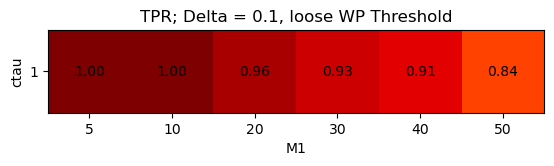

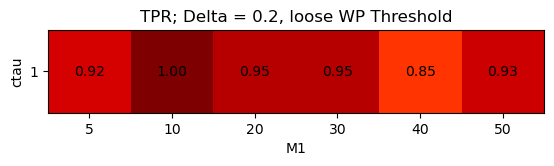

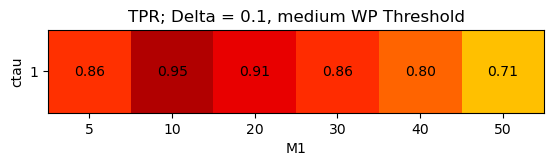

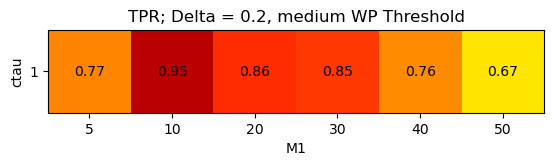

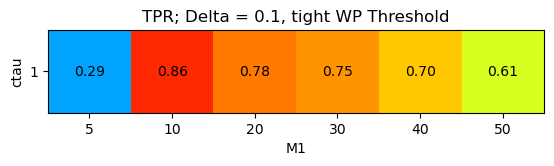

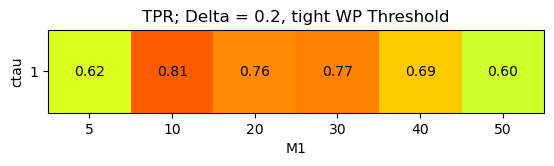

In [54]:
for wp in ['loose', 'medium', 'tight']:
    for delta in ['0.1', '0.2']:
        fig, ax = plt.subplots(1)
      
        arr = np.array([tpr_raw[delta]['ct-1'][wp]])
        
        ax.imshow(arr, interpolation ='none', cmap='jet', vmin=0, vmax=1)
        
        #plt.colorbar(im)
        
        for (j,i),label in np.ndenumerate(arr):
            label = '{:.2f}'.format(label)
            ax.text(i,j,label,ha='center',va='center')
        
        plt.title(f'TPR; Delta = {delta}, {wp} WP Threshold')
        plt.ylabel('ctau')
        plt.xlabel('M1')
        
        plt.xticks(range(0,6), [5, 10, 20, 30, 40, 50])
        plt.yticks(range(0,1), [1])
        plt.gca().invert_yaxis()
        
        plt.show()

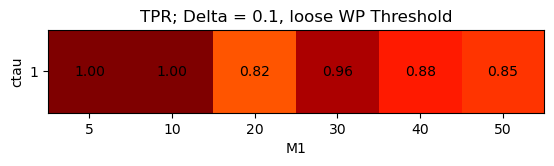

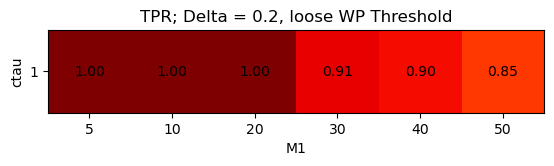

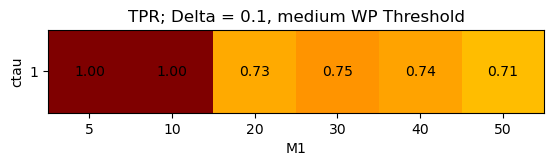

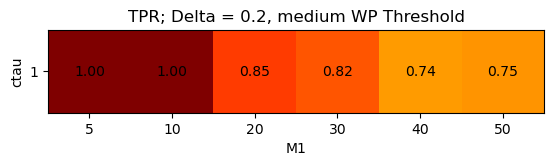

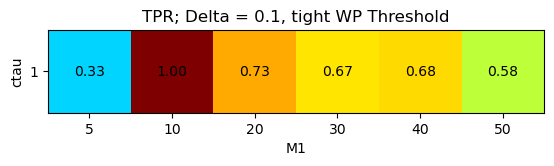

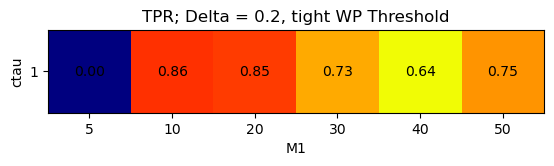

In [55]:
for wp in ['loose', 'medium', 'tight']:
    for delta in ['0.1', '0.2']:
        fig, ax = plt.subplots(1)
      
        arr = np.array([tpr_raw[delta]['ct-10'][wp]])
        
        ax.imshow(arr, interpolation ='none', cmap='jet', vmin=0, vmax=1)
        
        #plt.colorbar(im)
        
        for (j,i),label in np.ndenumerate(arr):
            label = '{:.2f}'.format(label)
            ax.text(i,j,label,ha='center',va='center')
        
        plt.title(f'TPR; Delta = {delta}, {wp} WP Threshold')
        plt.ylabel('ctau')
        plt.xlabel('M1')
        
        plt.xticks(range(0,6), [5, 10, 20, 30, 40, 50])
        plt.yticks(range(0,1), [1])
        plt.gca().invert_yaxis()
        
        plt.show()

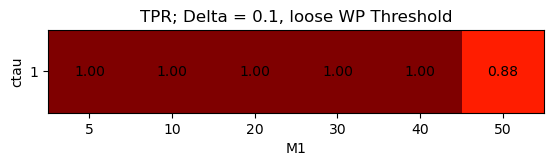

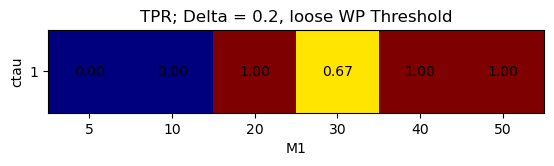

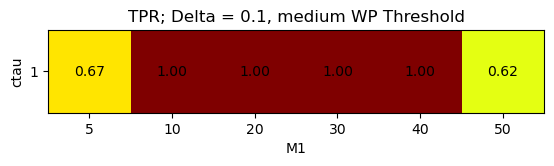

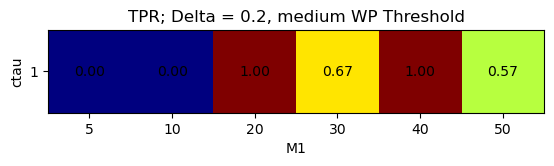

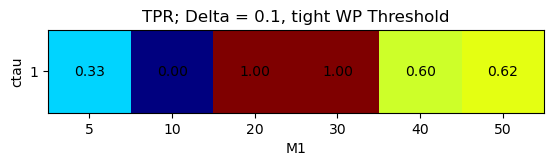

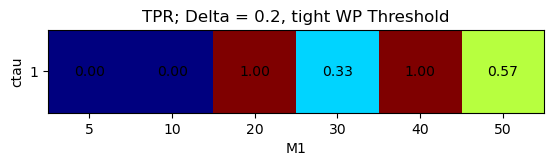

In [56]:
for wp in ['loose', 'medium', 'tight']:
    for delta in ['0.1', '0.2']:
        fig, ax = plt.subplots(1)
      
        arr = np.array([tpr_raw[delta]['ct-100'][wp]])
        
        ax.imshow(arr, interpolation ='none', cmap='jet', vmin=0, vmax=1)
        
        #plt.colorbar(im)
        
        for (j,i),label in np.ndenumerate(arr):
            label = '{:.2f}'.format(label)
            ax.text(i,j,label,ha='center',va='center')
        
        plt.title(f'TPR; Delta = {delta}, {wp} WP Threshold')
        plt.ylabel('ctau')
        plt.xlabel('M1')
        
        plt.xticks(range(0,6), [5, 10, 20, 30, 40, 50])
        plt.yticks(range(0,1), [1])
        plt.gca().invert_yaxis()
        
        plt.show()

### TPR on half dataset (not just 20%)

In [57]:
train_size = 0.5

sig_train, sig_test = train_test_split(sig_data,train_size=train_size,random_state=random_state)
sig_train_sf, sig_test_sf = train_test_split(sig_sf_arr, train_size=train_size, random_state=random_state)
sig_train_xsec_norm, sig_test_xsec_norm = train_test_split(sig_xsec_norm, train_size=train_size, random_state=random_state)
sig_train_m1, sig_test_m1 = train_test_split(sig_point['m1'], train_size=train_size, random_state=random_state)
sig_train_delta, sig_test_delta = train_test_split(sig_point['delta'], train_size=train_size, random_state=random_state)
sig_train_ctau, sig_test_ctau = train_test_split(sig_point['ctau'], train_size=train_size, random_state=random_state)

bkg_train, bkg_test = train_test_split(bkg_data,train_size=train_size,random_state=random_state)
bkg_train_sf, bkg_test_sf = train_test_split(bkg_sf_arr, train_size=train_size, random_state=random_state)
bkg_train_xsec_norm, bkg_test_xsec_norm = train_test_split(bkg_xsec_norm, train_size=train_size, random_state=random_state)

bkg_train_m1, bkg_test_m1 = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=train_size, random_state=random_state)
bkg_train_delta, bkg_test_delta = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=train_size, random_state=random_state)
bkg_train_ctau, bkg_test_ctau = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=train_size, random_state=random_state)

train = np.concatenate((sig_train,bkg_train),axis=0)
train_sf = np.concatenate((sig_train_sf,bkg_train_sf),axis=0)
train_sf = abs(train_sf)  # training sf cannot have negative values, genWgts have negative values, take abs for now, which is not correct :( 

y_train = np.concatenate((np.ones(len(sig_train)),np.zeros(len(bkg_train))),axis=0)

#perm = rng.permutation(len(train))
train = train[perm]
y_train = y_train[perm]
dtrain = xgb.DMatrix(train,label=y_train,feature_names=variables)

test = np.concatenate((sig_test,bkg_test),axis=0)
test_sf = np.concatenate((sig_test_sf,bkg_test_sf),axis=0) # not used

test_xsec_norm = np.concatenate((sig_test_xsec_norm, bkg_test_xsec_norm), axis=0)

test_m1 = np.concatenate((sig_test_m1,bkg_test_m1),axis=0)
test_delta = np.concatenate((sig_test_delta,bkg_test_delta),axis=0)
test_ctau = np.concatenate((sig_test_ctau,bkg_test_ctau),axis=0)

y_test = np.concatenate((np.ones(len(sig_test)),np.zeros(len(bkg_test))),axis=0)

#perm = rng.permutation(len(test))
test = test[perm]
y_test = y_test[perm]
test_xsec_norm = test_xsec_norm[perm]
test_m1 = test_m1[perm]
test_delta = test_delta[perm]
test_ctau = test_ctau[perm]

dtest = xgb.DMatrix(test,label=y_test,feature_names=variables)

In [58]:
preds = bst.predict(test)

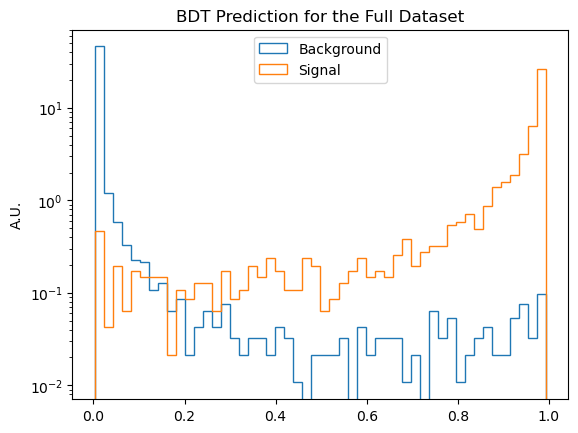

In [59]:
bins = 50

h,bins,_ = plt.hist(preds[y_test==0],bins=bins,density=True,histtype='step', label='Background')
h,bins,_ = plt.hist(preds[y_test==1],bins=bins,density=True,histtype='step', label='Signal')

plt.legend()
plt.title('BDT Prediction for the Full Dataset')

plt.ylabel('A.U.')
#plt.savefig('plots/BDTscore.png')
plt.yscale('log')

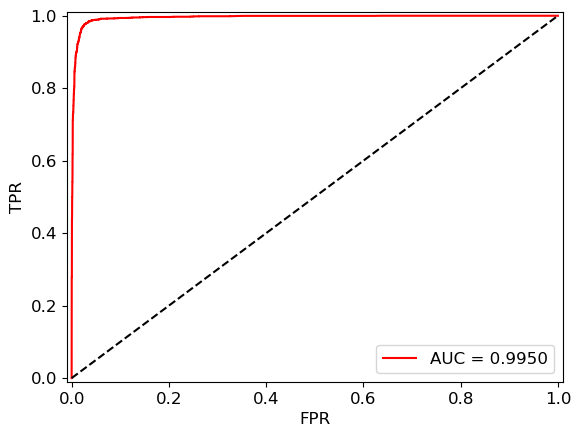

In [60]:
# ROC
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve

# make predictions

fpr, tpr, thresholds = roc_curve(y_test, preds)
auc = roc_auc_score(y_test, preds)
precision, recall, thresholds2 = precision_recall_curve(y_test, preds)

plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.4f}")

plt.plot([0,1], [0,1] , color = "black", ls = "--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('FPR' , fontsize=12)
plt.ylabel('TPR' , fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 4)
#plt.savefig('plots/roc_curve_weighted_training.png')

In [61]:
tpr_raw = { '0.1': {'ct-1': {'tight':[], 'medium':[], 'loose':[]}, 'ct-10': {'tight':[], 'medium':[], 'loose':[]}, 'ct-100': {'tight':[], 'medium':[], 'loose':[]}}, \
            '0.2': {'ct-1': {'tight':[], 'medium':[], 'loose':[]}, 'ct-10': {'tight':[], 'medium':[], 'loose':[]}, 'ct-100': {'tight':[], 'medium':[], 'loose':[]}}
          }

for ctau in [1., 10., 100.]:
    for delta in [0.1, 0.2]:
        for m1 in [5., 10., 20., 30., 40., 50.]:
            nPass_sig_raw_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
            nPass_bkg_raw_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
            
            for wp in nPass_sig.keys():
                sig_idx = np.where(((y_test==1) & (test_m1 == m1)) & ((test_delta == delta) & (test_ctau == ctau)))
                bkg_idx = np.where(y_test==0)
                
                nPass_sig_raw_sigpoint[wp] = np.sum(preds[sig_idx] > thres_WP[wp])
                nPass_bkg_raw_sigpoint[wp] = np.sum(preds[bkg_idx] > thres_WP[wp])

                if len(sig_idx[0]) == 0:
                    tpr_raw[f'{delta}'][f'ct-{int(ctau)}'][wp].append(0)
                    continue
                
                print(f'm1 = {m1}, delta = {delta}, ct = {ctau}')
                print(f'TPR: {nPass_sig_raw_sigpoint[wp]} / {len(sig_idx[0])} = {nPass_sig_raw_sigpoint[wp]/len(sig_idx[0])}')

                tpr_raw[f'{delta}'][f'ct-{int(ctau)}'][wp].append(nPass_sig_raw_sigpoint[wp]/len(sig_idx[0]))

m1 = 5.0, delta = 0.1, ct = 1.0
TPR: 11 / 17 = 0.6470588235294118
m1 = 5.0, delta = 0.1, ct = 1.0
TPR: 16 / 17 = 0.9411764705882353
m1 = 5.0, delta = 0.1, ct = 1.0
TPR: 17 / 17 = 1.0
m1 = 10.0, delta = 0.1, ct = 1.0
TPR: 56 / 81 = 0.691358024691358
m1 = 10.0, delta = 0.1, ct = 1.0
TPR: 71 / 81 = 0.8765432098765432
m1 = 10.0, delta = 0.1, ct = 1.0
TPR: 78 / 81 = 0.9629629629629629
m1 = 20.0, delta = 0.1, ct = 1.0
TPR: 94 / 122 = 0.7704918032786885
m1 = 20.0, delta = 0.1, ct = 1.0
TPR: 109 / 122 = 0.8934426229508197
m1 = 20.0, delta = 0.1, ct = 1.0
TPR: 119 / 122 = 0.9754098360655737
m1 = 30.0, delta = 0.1, ct = 1.0
TPR: 153 / 204 = 0.75
m1 = 30.0, delta = 0.1, ct = 1.0
TPR: 174 / 204 = 0.8529411764705882
m1 = 30.0, delta = 0.1, ct = 1.0
TPR: 195 / 204 = 0.9558823529411765
m1 = 40.0, delta = 0.1, ct = 1.0
TPR: 214 / 295 = 0.7254237288135593
m1 = 40.0, delta = 0.1, ct = 1.0
TPR: 249 / 295 = 0.8440677966101695
m1 = 40.0, delta = 0.1, ct = 1.0
TPR: 276 / 295 = 0.9355932203389831
m1 = 50.0, 

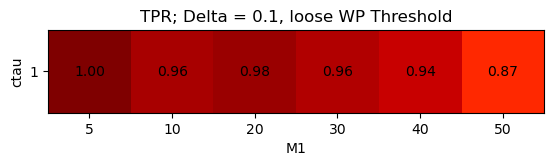

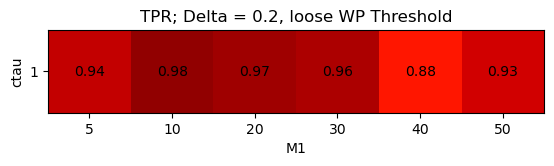

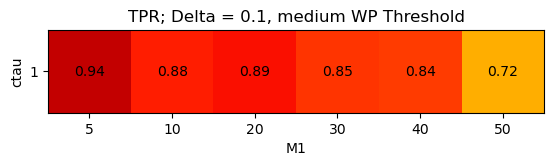

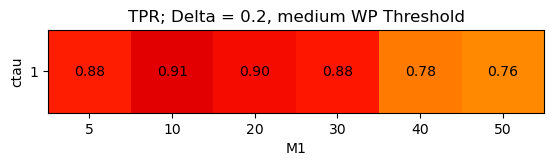

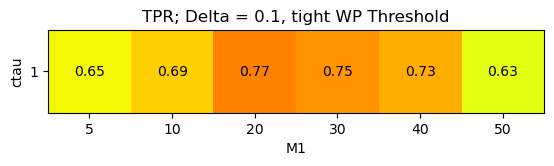

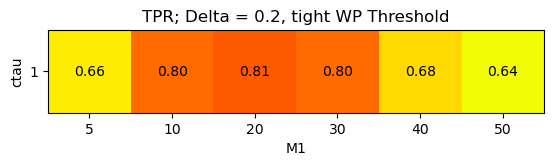

In [62]:
for wp in ['loose', 'medium', 'tight']:
    for delta in ['0.1', '0.2']:
        fig, ax = plt.subplots(1)
      
        arr = np.array([tpr_raw[delta]['ct-1'][wp]])
        
        ax.imshow(arr, interpolation ='none', cmap='jet', vmin=0, vmax=1)
        
        #plt.colorbar(im)
        
        for (j,i),label in np.ndenumerate(arr):
            label = '{:.2f}'.format(label)
            ax.text(i,j,label,ha='center',va='center')
        
        plt.title(f'TPR; Delta = {delta}, {wp} WP Threshold')
        plt.ylabel('ctau')
        plt.xlabel('M1')
        
        plt.xticks(range(0,6), [5, 10, 20, 30, 40, 50])
        plt.yticks(range(0,1), [1])
        plt.gca().invert_yaxis()
        
        plt.show()

### Pearson Correlation Coefficient

In [63]:
import pandas as pd

df_bkg = pd.DataFrame(bkg_data, columns = variables)
df_sig = pd.DataFrame(sig_data, columns = variables)
df_all = pd.DataFrame(np.concatenate((bkg_data,sig_data),axis=0), columns = variables)

In [64]:
corr_all = df_all.corr()
corr_bkg = df_bkg.corr()
corr_sig = df_sig.corr()

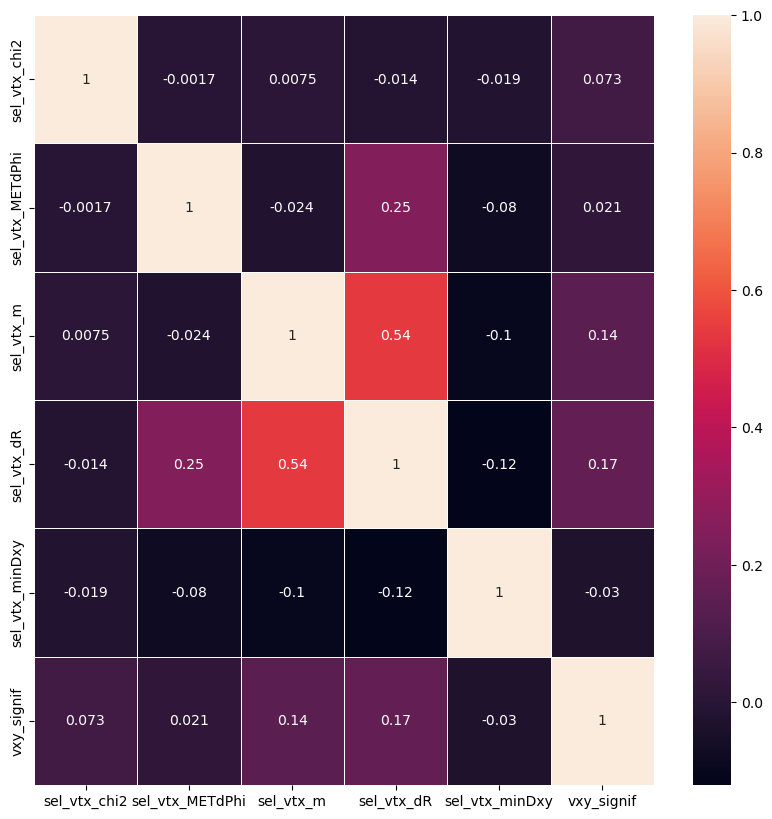

In [65]:
import seaborn as sb
from matplotlib.colors import LogNorm, Normalize

fig, ax = plt.subplots(figsize=(10,10))
ax = sb.heatmap(corr_all, annot=True, linewidths=.5)

Text(0.5, 1.0, 'PCC in Background Samples (Dataset size: 32301)')

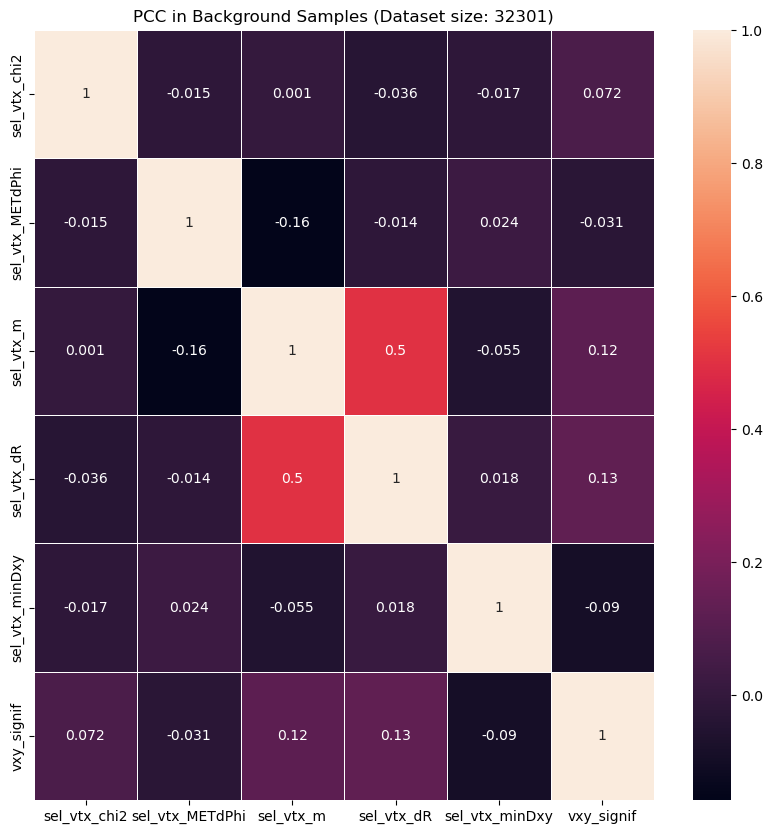

In [66]:


fig, ax = plt.subplots(figsize=(10,10))
ax = sb.heatmap(corr_bkg, annot=True, linewidths=.5)
plt.title(f'PCC in Background Samples (Dataset size: {bkg_data.shape[0]})') # Unweighted by xsec

Text(0.5, 1.0, 'PCC in Signal Samples (Dataset size: 5845)')

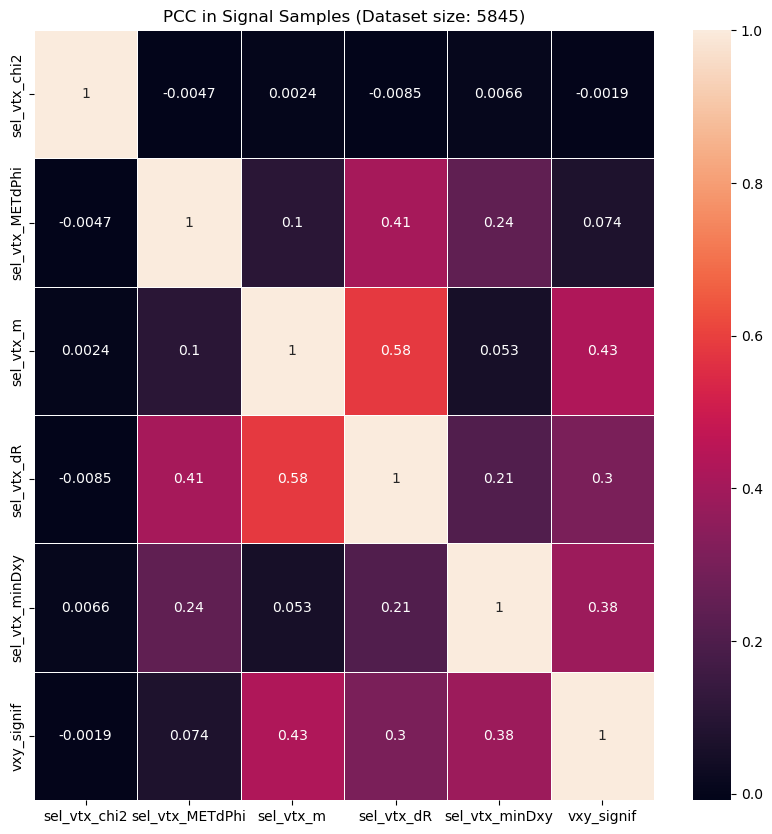

In [67]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sb.heatmap(corr_sig, annot=True, linewidths=.5)
plt.title(f'PCC in Signal Samples (Dataset size: {sig_data.shape[0]})')